In [1]:
pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from hdbscan.validity import validity_index
from dtaidistance import dtw
import plotly.express as px
from PIL import Image

In [3]:
df = pd.read_csv('windows_hi.csv')
df

,Finestra,batterie,inverter,conversione,scaricatori,controllo,raffreddamento
0,1,0.5114,0.5269,0.5009,0.5371,0.5012,0.5234
1,2,0.5229,0.5070,0.5098,0.5371,0.5256,0.5330
2,3,0.5126,0.5180,0.5133,0.5170,0.5090,0.5323
3,4,0.5063,0.5067,0.5058,0.5170,0.5022,0.5185
4,5,0.5174,0.4994,0.5007,0.5371,0.5265,0.5120
...,...,...,...,...,...,...,...
494,495,0.5119,0.5298,0.5049,0.4967,0.5191,0.5176
495,496,0.4992,0.5430,0.5083,0.5170,0.5191,0.5238
496,497,0.5065,0.4901,0.5088,0.5169,0.5282,0.5250
497,498,0.5188,0.4842,0.4958,0.5372,0.5333,0.5246


In [4]:
df_num = df.select_dtypes(include='float64')

In [5]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# TSNE (t-distributed Stochastic Neighbor Embedding)

In [6]:
def tsne_plot(df, cluster_labels, title='t-SNE Visualization', save_path='figure.png'):

    tsne_3d = TSNE(n_components=3, perplexity=30, init='pca', random_state=42)
    tsne_results = tsne_3d.fit_transform(df)
    df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2', 'TSNE3'])
    df_tsne['cluster_name'] = cluster_labels

    # Colors
    unique_clusters = df_tsne['cluster_name'].unique()
    palette = sns.color_palette("coolwarm", n_colors=len(unique_clusters))
    cluster_colors = {}
    for i, name in enumerate(unique_clusters):
        if 'anomaly' in str(name).lower():
          cluster_colors[name] = (1.0, 0.0, 0.0)  # rosso
        else:
          cluster_colors[name] = palette[i]
    df_tsne['color'] = df_tsne['cluster_name'].map(cluster_colors)

    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for name in unique_clusters:
        mask = df_tsne['cluster_name'] == name
        ax.scatter(
            df_tsne.loc[mask, 'TSNE1'],
            df_tsne.loc[mask, 'TSNE2'],
            df_tsne.loc[mask, 'TSNE3'],
            c=[cluster_colors[name]],
            label=name,
            alpha=0.7,
            s=40
        )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('TSNE1')
    ax.set_ylabel('TSNE2')
    ax.set_zlabel('TSNE3')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [7]:
def tsne_plot_3d(X, cluster_labels, title='t-SNE 3D Visualization'):

    tsne = TSNE(n_components=3, perplexity=30, init='pca', random_state=42)
    tsne_result = tsne.fit_transform(X)

    df_tsne = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2', 'TSNE3'])
    df_tsne['cluster_name'] = cluster_labels

    # Plot 3D
    fig = px.scatter_3d(
        df_tsne,
        x='TSNE1',
        y='TSNE2',
        z='TSNE3',
        color='cluster_name',
        title=title,
        opacity=0.7
    )

    fig.update_traces(marker=dict(size=5))
    fig.update_layout(
        legend_title_text='Cluster',
        scene=dict(
            xaxis_title='TSNE1',
            yaxis_title='TSNE2',
            zaxis_title='TSNE3'
        )
    )

    fig.show()

# Hyperparameter tuning

Elbow method

In [8]:
def elbow_method(X, min_samples_list=range(3, 9), metric='euclidean', VI=None):

    if metric == 'mahalanobis':
        if VI is None:
            cov = np.cov(X.T)
            cov += np.eye(cov.shape[0]) * 1e-6  # Regolarization
            VI = np.linalg.inv(cov)

    plt.figure(figsize=(12, 6))

    for k in min_samples_list:
        kwargs = {'metric': metric}
        if metric == 'mahalanobis':
            kwargs['metric_params'] = {'VI': VI}

        neigh = NearestNeighbors(n_neighbors=k, **kwargs)
        neigh.fit(X)
        distances, _ = neigh.kneighbors(X)

        kth_distances = np.sort(distances[:, k - 1])
        plt.plot(kth_distances, label=f'min_samples = {k}')

    plt.title("Elbow Method")
    plt.xlabel("Punti ordinati per distanza")
    plt.ylabel("Distanza al k-esimo vicino più vicino")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


GridSearch with DBCV

In [9]:
def grid_dbscan_dbcv(X, metric, eps_range=np.arange(0.015, 0.030, 0.001), min_samples_range=range(3, 8)):
    results = []

    if metric == 'mahalanobis':
        VI = np.linalg.inv(np.cov(X.T))
        distance_matrix = pairwise_distances(X, metric='mahalanobis', VI=VI)
    else:
        VI = None
        distance_matrix = pairwise_distances(X, metric=metric)

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
            labels = dbscan.fit_predict(distance_matrix)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_outliers = np.sum(labels == -1)

            # Calcolo del DBCV solo se ci sono almeno 2 cluster
            dbcv = validity_index(distance_matrix, labels) if n_clusters >= 2 else -1

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'dbcv': dbcv,
                'n_clusters': n_clusters,
                'n_outliers': n_outliers
            })

    results_df = pd.DataFrame(results).sort_values(by='dbcv', ascending=False)
    best = results_df.iloc[0]
    print(f"Migliori parametri trovati: eps={best['eps']}, min_samples={best['min_samples']}, dbcv={best['dbcv']:.3f}")
    return results_df


GRID SEARCH with silhouette score

In [10]:
def grid_search_dbscan_silhouette(X, metric, eps_values=np.arange(1, 2, 0.01), min_samples_values=range(3, 8)):
    results = []

    VI = None
    if metric == 'mahalanobis':
        cov = np.cov(X.T)
        cov += np.eye(cov.shape[0]) * 1e-6  # regolarizzazione
        VI = np.linalg.inv(cov)

    for eps in eps_values:
        for min_samples in min_samples_values:
            if metric == 'mahalanobis':
                dbscan = DBSCAN(eps=eps, min_samples=min_samples,
                                metric='mahalanobis', metric_params={'VI': VI})
            else:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)

            labels = dbscan.fit_predict(X)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters >= 2 and len(set(labels)) < len(X):
                sil_score = silhouette_score(X, labels)
            else:
                sil_score = -1

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette_score': sil_score
            })

    results_df = pd.DataFrame(results).sort_values(by='silhouette_score', ascending=False)
    best_valid = results_df[results_df['silhouette_score'] > -1].head(1)

    if not best_valid.empty:
        best = best_valid.iloc[0]
        print(f"Migliori parametri: eps={best['eps']}, min_samples={best['min_samples']}, silhouette={best['silhouette_score']:.3f}")
    else:
        print("Nessun clustering valido trovato (almeno 2 cluster).")

    return results_df


# DBSCAN

**DBSCAN euclidean distance**

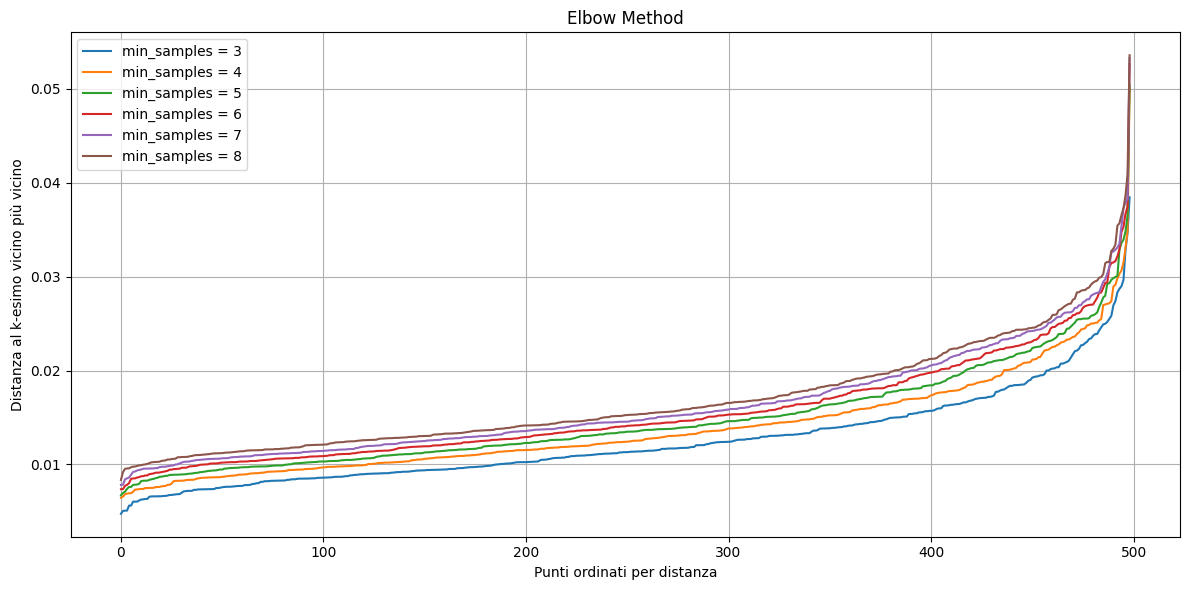

In [11]:
elbow_method(df_num, metric='euclidean')

In [12]:
grid_dbscan_dbcv(df_num, 'euclidean')

/usr/local/lib/python3.11/dist-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/usr/local/lib/python3.11/dist-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/usr/local/lib/python3.11/dist-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/usr/local/lib/python3.11/dist-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/usr/local/lib/python3.11/dist-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/usr/local/lib/python3.11/dist-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance

Migliori parametri trovati: eps=0.021000000000000005, min_samples=5.0, dbcv=0.408


,eps,min_samples,dbcv,n_clusters,n_outliers
32,0.021,5,0.408413,2,32
31,0.021,4,0.319497,2,26
38,0.022,6,0.268427,2,29
35,0.022,3,0.246572,2,15
2,0.015,5,0.184201,3,114
...,...,...,...,...,...
70,0.029,3,-1.000000,1,4
71,0.029,4,-1.000000,1,4
72,0.029,5,-1.000000,1,4
73,0.029,6,-1.000000,1,4


In [13]:
eps_selected = 0.021
min_sample = 5
dbscan = DBSCAN(eps= eps_selected, min_samples= min_sample)
labels_euc = dbscan.fit_predict(df_num)
df['cluster'] = labels_euc
df['anomaly'] = (labels_euc == -1).astype(int)  # -1 = anomalia

# Mappatura
label_mapping = {label: f"cluster_{label}" for label in set(labels_euc) if label != -1}
label_mapping[-1] = "anomaly"
df['cluster_name'] = df['cluster'].map(label_mapping)

print(df['cluster_name'].value_counts())

cluster_name
cluster_0    462
anomaly       32
cluster_1      5
Name: count, dtype: int64


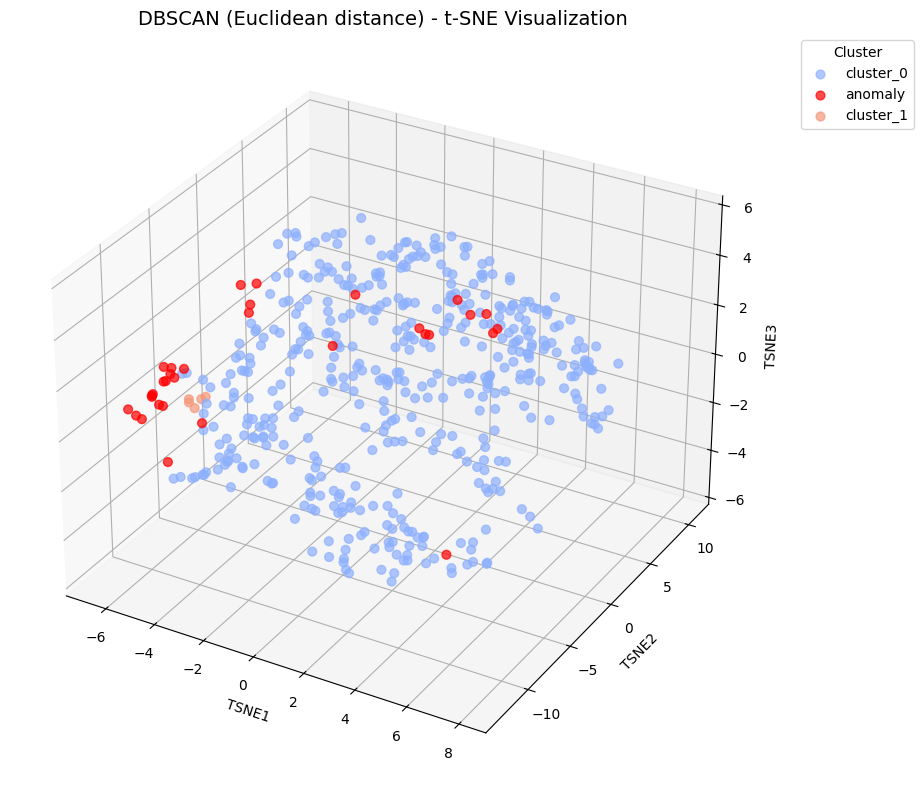

In [14]:
tsne_plot(
    df_num,
    cluster_labels= df['cluster_name'],
    title='DBSCAN (Euclidean distance) - t-SNE Visualization',
    save_path='fig1.png'
)

In [15]:
tsne_plot_3d(df_num, df['cluster_name'], title='DBSCAN (Euclidean distance) - t-SNE (3D)')

**DBSCAN mahalanobis distance**

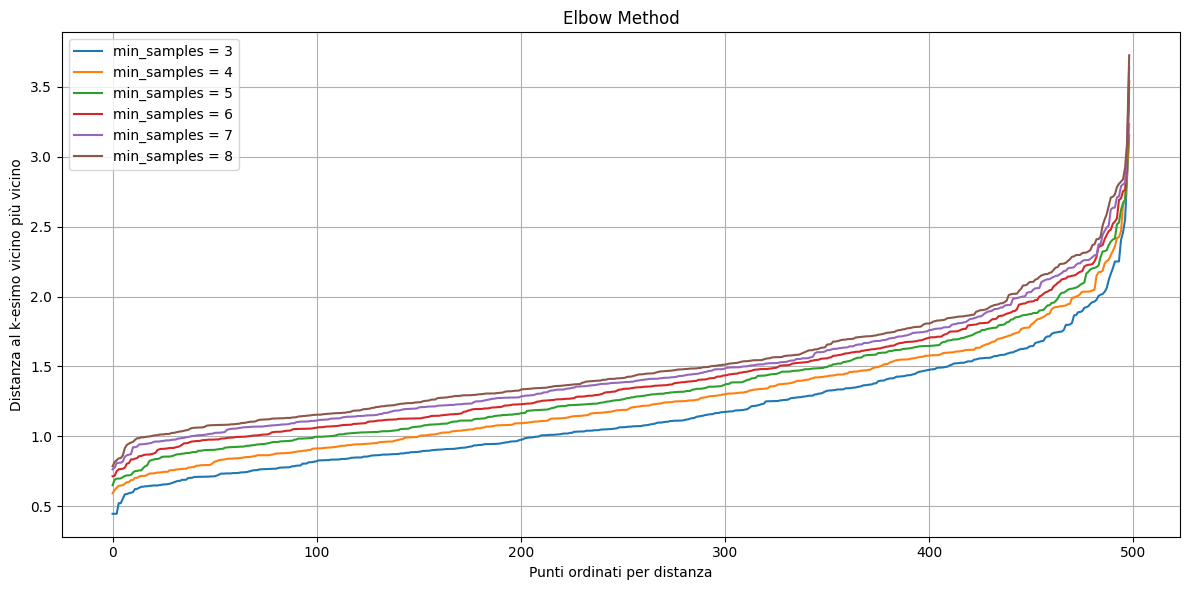

In [16]:
elbow_method(df_scaled, metric='mahalanobis')

In [17]:
grid_search_dbscan_silhouette(df_scaled, 'mahalanobis')

Migliori parametri: eps=1.5900000000000005, min_samples=4.0, silhouette=0.216


,eps,min_samples,n_clusters,silhouette_score
296,1.59,4,2,0.215625
295,1.59,3,2,0.212399
285,1.57,3,2,0.200708
290,1.58,3,2,0.200708
317,1.63,5,2,0.192885
...,...,...,...,...
267,1.53,5,1,-1.000000
266,1.53,4,1,-1.000000
113,1.22,6,1,-1.000000
239,1.47,7,1,-1.000000


In [18]:
eps_mah = 1.597
min_sample_mah = 4

VI = np.linalg.inv(np.cov(df_scaled.T)) # The inverse of the covariance matrix of the scaled data

dbscan = DBSCAN(eps= eps_mah, min_samples= min_sample_mah, metric='mahalanobis', metric_params={'VI': VI})
labels_mah = dbscan.fit_predict(df_scaled)
df['cluster_mah'] = labels_mah
df['anomaly_mah'] = (labels_mah == -1).astype(int)

# Mappatura
label_mapping = {label: f"cluster_{label}" for label in set(labels_mah) if label != -1}
label_mapping[-1] = "anomaly_mah"
df['cluster_name_mah'] = df['cluster_mah'].map(label_mapping)

print(df['cluster_name_mah'].value_counts())

cluster_name_mah
cluster_0      451
anomaly_mah     44
cluster_1        4
Name: count, dtype: int64


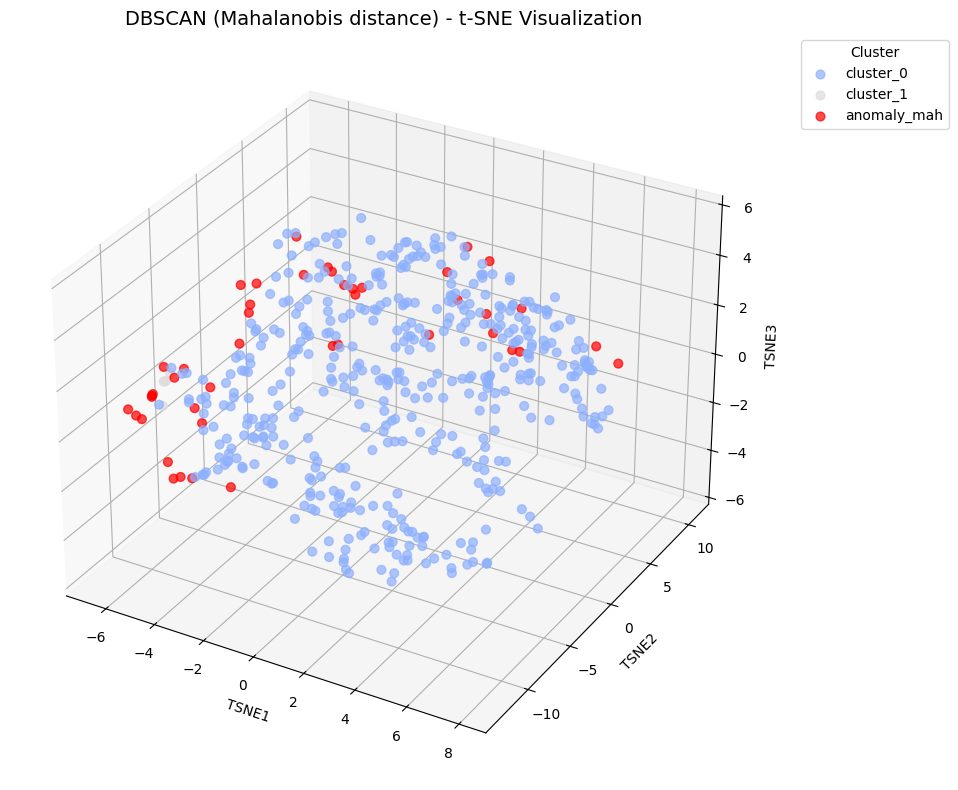

In [19]:
tsne_plot(
    df_num,
    cluster_labels=df['cluster_name_mah'],
    title='DBSCAN (Mahalanobis distance) - t-SNE Visualization',
    save_path='fig2.png'
)

In [20]:
tsne_plot_3d(df_num, df['cluster_name_mah'], title='DBSCAN (Mahalanobis distance) - t-SNE (3D)')

# Analisi risultati cluster

Numero di outlier trovati:
DBSCAN - Euclidean distance: 32
DBSCAN - Mahalanobis distance: 44
Numero di punti classificati come outlier da entrambe le metriche: 21
 


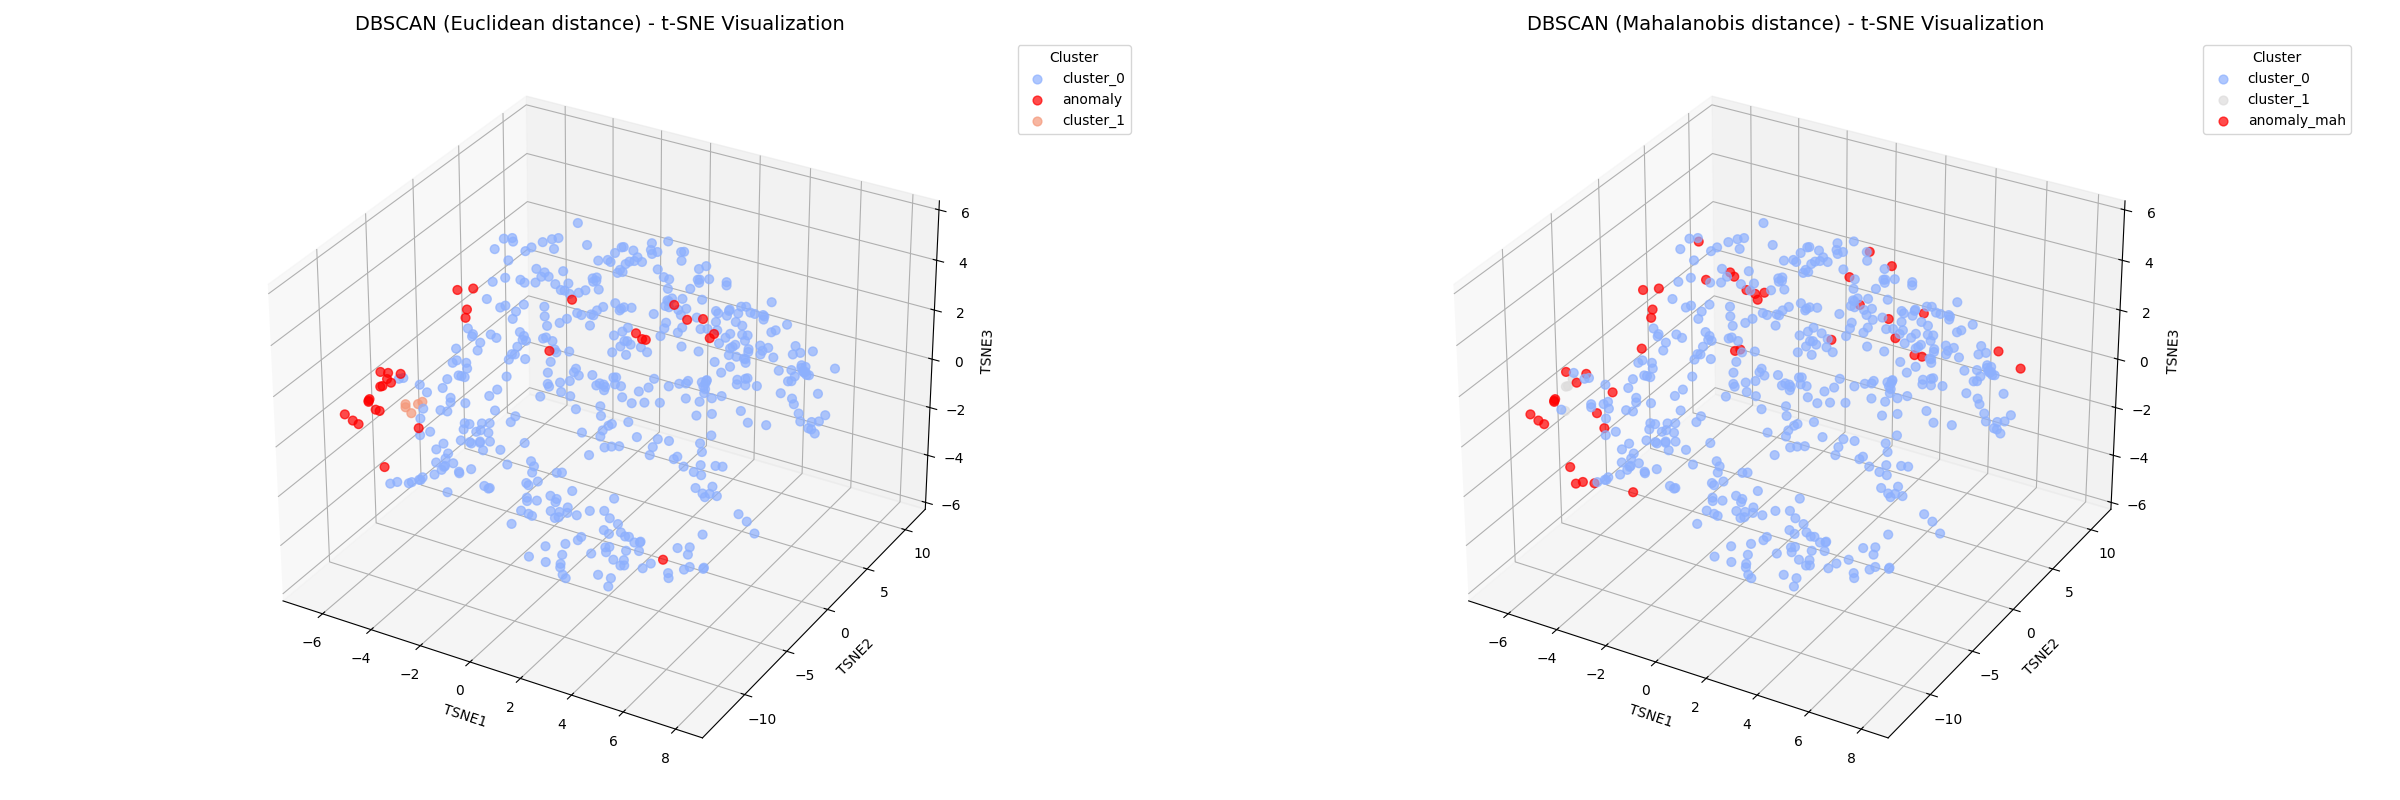

In [21]:
df_compare = pd.DataFrame({
    'euclidean': labels_euc,
    'mahalanobis': labels_mah,
})

df_compare['outlier_euc'] = (df_compare['euclidean'] == -1).astype(int)
df_compare['outlier_mah'] = (df_compare['mahalanobis'] == -1).astype(int)
mask_both = (df_compare['outlier_euc'] == 1) & (df_compare['outlier_mah'] == 1)
n_outliers_both = mask_both.sum()

print("Numero di outlier trovati:")
print("DBSCAN - Euclidean distance:", df_compare['outlier_euc'].sum())
print("DBSCAN - Mahalanobis distance:", df_compare['outlier_mah'].sum())
print('Numero di punti classificati come outlier da entrambe le metriche:', n_outliers_both)
print(" ")

# Plot together
img1 = Image.open("fig1.png")
img2 = Image.open("fig2.png")

# Match altezze
if img1.height != img2.height:
    new_height = min(img1.height, img2.height)
    img1 = img1.resize((int(img1.width * new_height / img1.height), new_height))
    img2 = img2.resize((int(img2.width * new_height / img2.height), new_height))

total_width = img1.width + img2.width
combined_img = Image.new("RGB", (total_width, img1.height))
combined_img.paste(img1, (0, 0))
combined_img.paste(img2, (img1.width, 0))
combined_img.save("combined_plots.png")

display(combined_img)

**SubPlots Anomalies**

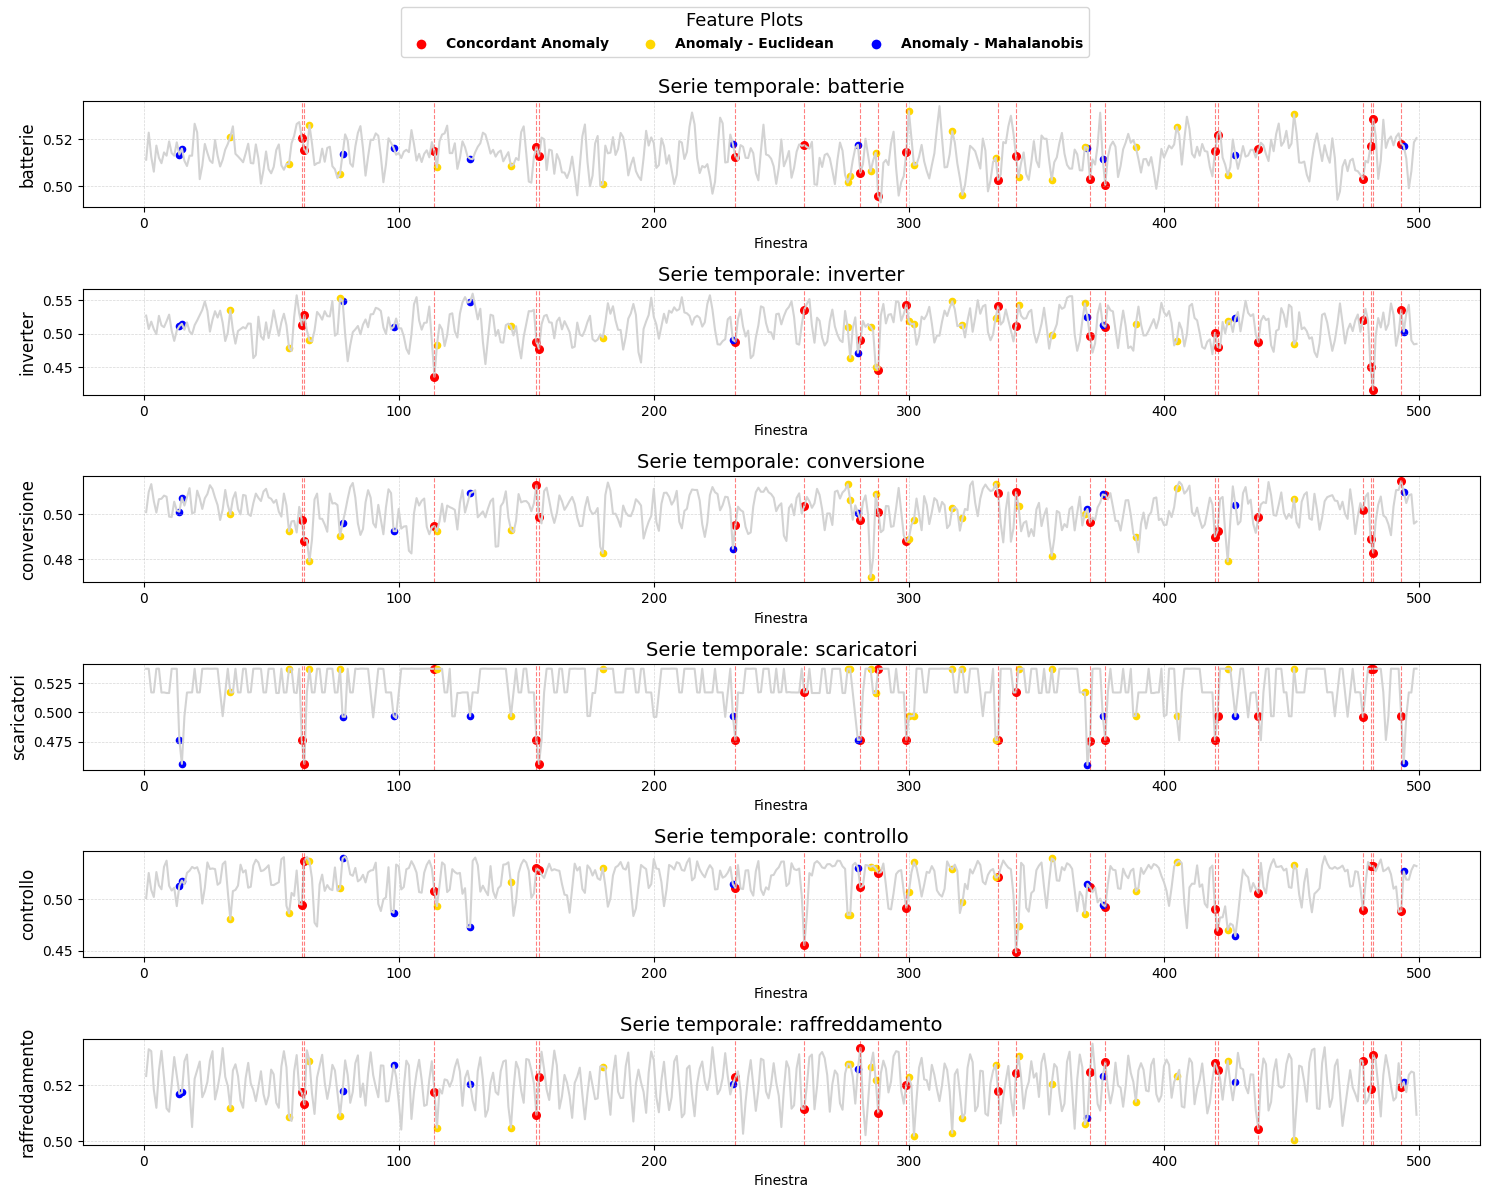

In [22]:
columns_to_plot = df.drop(['Finestra', 'anomaly', 'cluster', 'cluster_name',
                           'cluster_mah', 'anomaly_mah', 'cluster_name_mah'], axis=1).columns
n_vars = len(columns_to_plot)

f, ax = plt.subplots(nrows=n_vars, ncols=1, figsize=(15, 2 * n_vars))
if n_vars == 1:
    ax = [ax]

# Anomalies' mask
mask = df['anomaly'] == 1
mask_2 = df['anomaly_mah'] == 1
mask_overlap = mask & mask_2

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Concordant Anomaly',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Anomaly - Euclidean',
           markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Anomaly - Mahalanobis',
           markerfacecolor='blue', markersize=8)
]

# Plot per ogni variabile
for i, column in enumerate(columns_to_plot):
    sns.lineplot(x=df['Finestra'], y=df[column], ax=ax[i], color='lightgrey')

    # Linee verticali gialle tratteggiate
    for x in df['Finestra'][mask_overlap]:
        ax[i].axvline(x=x, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

    # Rosso: entrambe le anomalie
    ax[i].scatter(df['Finestra'][mask_overlap], df[column][mask_overlap],
                  color='red', s=30, label='Anomaly Both')

    # Blu: solo Euclidean
    ax[i].scatter(df['Finestra'][mask & ~mask_overlap], df[column][mask & ~mask_overlap],
                  color='blue', s=20, label='Anomaly - Euclidean')

    # Giallo: solo Mahalanobis
    ax[i].scatter(df['Finestra'][mask_2 & ~mask_overlap], df[column][mask_2 & ~mask_overlap],
                  color='gold', s=20, label='Anomaly - Mahalanobis')

    ax[i].set_title(f'Serie temporale: {column}', fontsize=14)
    ax[i].set_ylabel(column, fontsize=12)

    ax[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

f.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=10, title='Feature Plots', title_fontsize=13, prop={'weight': 'bold'})
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('anomalies.png')

plt.show()
